For this project, I'll employ Linear Regression to determine the features that are most predictive of housing prices in Ames, Iowa from 2006 to 2010.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold

In [87]:
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
housing.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


I'll start by exploring and cleaning the data set. 

In [88]:
housing.columns

housing.shape

(2930, 82)

In [89]:
housing.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
                   ...   
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces          int64
Fireplace Qu       object
Garage Type 

In [90]:
housing.isnull().sum()

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

I'll go ahead and include only my numerical columns, drop irrelevant columns, and built a new column that will provide a more relevant value.

In [91]:
housing = housing.select_dtypes(include=['float','integer'])
#Finding training features - FEATURE Engineering
housing['years_until_remod'] = housing['Year Remod/Add'] - housing['Year Built']
#The above column is more useful that knowing just the year a home was remodeled or built. 
housing = housing.drop(labels=['Order'],axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 39 columns):
PID                  2930 non-null int64
MS SubClass          2930 non-null int64
Lot Frontage         2440 non-null float64
Lot Area             2930 non-null int64
Overall Qual         2930 non-null int64
Overall Cond         2930 non-null int64
Year Built           2930 non-null int64
Year Remod/Add       2930 non-null int64
Mas Vnr Area         2907 non-null float64
BsmtFin SF 1         2929 non-null float64
BsmtFin SF 2         2929 non-null float64
Bsmt Unf SF          2929 non-null float64
Total Bsmt SF        2929 non-null float64
1st Flr SF           2930 non-null int64
2nd Flr SF           2930 non-null int64
Low Qual Fin SF      2930 non-null int64
Gr Liv Area          2930 non-null int64
Bsmt Full Bath       2928 non-null float64
Bsmt Half Bath       2928 non-null float64
Full Bath            2930 non-null int64
Half Bath            2930 non-null int64
Bedroom AbvGr   

The following function will narrow down my data set to include rows columns with relatively few null values, and it will replace the remaining null values with the most frequent value, or the column's average. 

In [92]:
def transform_features(dataframe):
    null_sum = dataframe.isnull().sum()
    no_nulls = null_sum[null_sum < 150]
    dataframe = dataframe[no_nulls.index] 
    dataframe = dataframe.fillna(dataframe.mode())
    dataframe = dataframe.fillna(dataframe.mean())
    
    return dataframe

In [93]:
housing = transform_features(housing)


I'll now need to determine which features correlate most strongly with my target value. The following work highlights my process.

In [94]:
h_corr = housing.corr()
abs_corr = abs(h_corr['SalePrice']).sort_values()
strong_corr = abs_corr[abs_corr > .3]
strong_corr

Open Porch SF     0.312951
Wood Deck SF      0.327143
BsmtFin SF 1      0.432794
Fireplaces        0.474558
TotRms AbvGrd     0.495474
Mas Vnr Area      0.505784
Year Remod/Add    0.532974
Full Bath         0.545604
Year Built        0.558426
1st Flr SF        0.621676
Total Bsmt SF     0.632105
Garage Area       0.640385
Garage Cars       0.647861
Gr Liv Area       0.706780
Overall Qual      0.799262
SalePrice         1.000000
Name: SalePrice, dtype: float64

The above values correlate most strongly with home value. My next step will be to spot values that correlate strongly with each other. Removing these will allow me to avoid collinearity within my model.

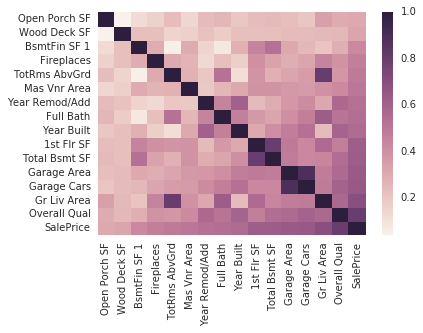

In [95]:
map = housing[strong_corr.index].corr()
sns.heatmap(map)

It appears Total Rooms Above Ground is strongly correlated with Garage Living Area and Total Rooms Above Ground. I'll go ahead and drop Gr Living Area from my data set. Naturally, Garage Area and Garage Cars are related as they both describe the garage's size - I'll remove Garage Cars. 

In [96]:
#Knowing the total years it's been since the home was built is more helpful for our model than knowing the actual year it was built.
housing['Years Since Built'] = 2019 - housing['Year Built']
housing = housing.drop(labels=['Year Built','Gr Liv Area','Garage Cars'],axis=1)

I'll incorporate the logic above into the below function.

In [107]:
def select_features(dataframe):
    corr = dataframe.corr()
    abs_corr = abs(corr['SalePrice']).sort_values()
    strong_corr = abs_corr[abs_corr > .3]
    return dataframe[strong_corr.index]

The regression model is embedded within the following function, which returns root mean squared error values for a specified value of k. This will be my final model.

In [98]:
def train_and_test(dataframe,k=0):
    ln = LinearRegression()
    if k==0:
        train = dataframe[:1460]
        test = dataframe[1460:]
    
        train_n = train.select_dtypes(include=['integer','float'])
        test_n = test.select_dtypes(include=['integer','float'])
        train_cols = train_n.columns.drop('SalePrice')
    
        ln.fit(train_n[train_cols],train_n['SalePrice'])
        predict = ln.predict(test_n[train_cols])
        rmse = np.sqrt(mean_squared_error(test_n['SalePrice'],predict))
        return rmse
    if k==1:
        new_index = np.random.permutation(dataframe.index)
        dataframe = dataframe.reindex(new_index)
        dataframe = dataframe.select_dtypes(include=['integer','float'])
        
        fold_one = dataframe[:1460]
        fold_two = dataframe[1460:]
        fold_cols = fold_one.columns.drop('SalePrice')
        
        ln.fit(fold_one[fold_cols],fold_one['SalePrice'])
        predict_one = ln.predict(fold_two[fold_cols])
        rmse_one = np.sqrt(mean_squared_error(fold_two['SalePrice'],predict_one))
        
        ln.fit(fold_two[fold_cols],fold_two['SalePrice'])
        predict_two = ln.predict(fold_one[fold_cols])
        rmse_two = np.sqrt(mean_squared_error(fold_one['SalePrice'],predict_two))
        
        avg_rmse = np.mean([rmse_one,rmse_two])
        #print(rmse_one,rmse_two)
        return avg_rmse
    if k > 1:
        dataframe = dataframe.select_dtypes(include=['integer','float'])
        train = dataframe[:1460]
        train_cols = train.columns.drop('SalePrice')
        kf = KFold(k,shuffle=True)
        mses = cross_val_score(ln,train[train_cols],train['SalePrice'],
                               scoring='neg_mean_squared_error',cv=kf)
        avg_rmse = np.mean(np.sqrt(abs(mses)))
        #print(mses)
        return avg_rmse
    

In [110]:
housing = transform_features(housing)
housing = select_features(trans)
rmse = train_and_test(filtered_df)

rmse

41796.36114924259

The above value is the squared difference between our actual and predicted home value, using the features that were filtered out. Note that I use the default value of k, which is 0. This means that I simply split the test and training data based on position in the data frame. Increasing the value of k enables the model to shuffle the order of my data frame, split it into k parts, and then run my regression model. Let's run the model on different values of k.

In [111]:
train_and_test(housing,1)

36643.179356856155

In [112]:
train_and_test(housing,4)

31149.009032713533

In [113]:
errors = []
for i in range(0,10):
    error = train_and_test(housing,i)
    errors.append(error)

In [114]:
errors

[41796.36114924259,
 36135.248467943646,
 31017.14923146936,
 31130.699882458808,
 31309.750668430614,
 30994.505307750893,
 30822.210884825647,
 30900.27941575126,
 30997.06686696995,
 30865.802733327306]

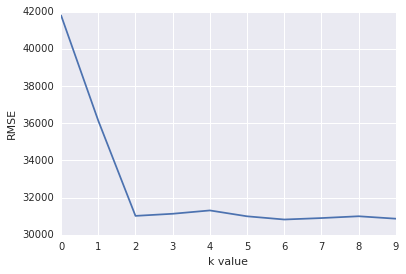

In [115]:
k_dict = {}
for i, error in enumerate(errors):
    k_dict[i] = error

x = list(k_dict.keys())
y = list(k_dict.values())
plt.plot(x,y)
plt.xlabel('k value')
plt.ylabel('RMSE')

The graph shows that the value of k which minimizes our error between expected and actual housing prices is 6, using the following features.

In [120]:
features = housing.columns.drop('SalePrice')
print(features)

Index(['Open Porch SF', 'Wood Deck SF', 'BsmtFin SF 1', 'Fireplaces',
       'TotRms AbvGrd', 'Mas Vnr Area', 'Year Remod/Add', 'Full Bath',
       'Years Since Built', '1st Flr SF', 'Total Bsmt SF', 'Garage Area',
       'Overall Qual'],
      dtype='object')
